In [1]:
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch, torchdata, torchtext
from torch import nn

import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [4]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [5]:
torch.__version__

'1.13.1+cu116'

In [6]:
torchtext.__version__

'0.14.1'

In [7]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install pytreebank

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!python -m spacy download en_core_web_sm

2023-02-16 14:58:37.734157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 14:58:38.647694: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-16 14:58:38.647815: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-16 14:58:38.647836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [10]:
#@title Load data
import pytreebank
dataset = pytreebank.load_sst()

In [11]:
train = dataset["train"]
valid = dataset["dev"]
test  = dataset["test"]

In [12]:
print(len(list(iter(train))), len(list(iter(valid))), len(list(iter(test))))

8544 1101 2210


In [13]:
def get(data):
    list_sentence  = list()
    list_label = list()
    lenght = len(list(iter(data)))
    for i in range(lenght):
        for label, sentence in data[i].to_labeled_lines():
            list_sentence.append(sentence)
            list_label.append(label)
    
    return (list_sentence, list_label)

In [14]:
train_data, train_label = get(dataset["train"])
valid_data, valid_label = get(dataset["dev"])
test_data,  test_label  = get(dataset["test"])

print(len(train_data), len(valid_data), len(test_data))

318582 41447 82600


In [15]:
#let's take a look at one example of train_data, train_label
print(next(iter(train_data)))
print(next(iter(train_label)))

The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
3


In [16]:
#@title Preprocessing

#pip install spacy
#python3 -m spacy download en_core_web_sm
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens = tokenizer("We are learning torchtext in AIT!")  #some test
tokens

['We', 'are', 'learning', 'torchtext', 'in', 'AIT', '!']

In [17]:
#@title Text to integers (numeral)

from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):
    for data in data_iter:
        for _, text in data.to_labeled_lines():
            yield tokenizer(text)
        
vocab = build_vocab_from_iterator(yield_tokens(train), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

In [18]:
#see some example
vocab(['here', 'is', 'a', 'unknownword', 'a'])

[215, 13, 6, 0, 6]

In [19]:
#we can reverse it....
mapping = vocab.get_itos()

#print 6, for example
mapping[6]

'a'

In [20]:
#let's try unknown vocab
vocab(['dddd', 'aaaa'])
#they will all map to <unk> which has 0 as integer

[0, 0]

In [21]:
#let's try special symbols
vocab(['<pad>', '<bos>', '<eos>'])

[1, 2, 3]

In [22]:
#so we can 10k+ unique vocabularies!
len(vocab)

17136

In [23]:
#@title FastText Embeddings

from torchtext.vocab import FastText
fast_vectors = FastText(language='simple') #small for easy training

In [24]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)
# vocab.get_itos() returns a list of strings (tokens), where the token at the i'th position is what you get from doing vocab[token]
# get_vecs_by_tokens gets the pre-trained vector for each string when given a list of strings
# therefore pretrained_embedding is a fully "aligned" embedding matrix

In [25]:
fast_embedding.shape   #we have 17136 vocabs, each with a 300 fasttext embedding

torch.Size([17136, 300])

In [26]:
#@title Preparing the dataloader

text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) #turn {1, 2, 3, 4} to {0, 1, 2, 3} for pytorch training 

In [27]:
text_pipeline("I love to play football")

[63, 110, 9, 494, 8735]

In [28]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #making each batch same length

pad_ix = vocab['<pad>']

#this function gonna be called by DataLoader
def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0)) #for padding
        
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=pad_ix, batch_first=True), torch.tensor(length_list, dtype=torch.int64)

In [29]:
#combine sentence and label together
training_set = [(train_label[i], train_data[i]) for i in range(0, len(train_data))]
validating_set = [(valid_label[i], valid_data[i]) for i in range(0, len(valid_data))]
testing_set = [(test_label[i], test_data[i]) for i in range(0, len(test_data))]

In [30]:
#take a quick check
next(iter(training_set))

(3,
 "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .")

In [31]:
batch_size = 64

train_loader = DataLoader(training_set, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(validating_set, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(testing_set, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

In [32]:
for label, text, length in train_loader:
    break

In [33]:
print("Label shape: ", label.shape) # (batch_size, )
print("Text shape: ", text.shape)   # (batch_size, seq len)

Label shape:  torch.Size([64])
Text shape:  torch.Size([64, 26])


In [34]:
#@title Design the model


import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()
        #put padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_ix)
        self.lstm = nn.LSTM(emb_dim, 
                           hid_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hid_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        #text = [batch size, seq len]
        embedded = self.embedding(text)
        
        #++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
        
        #embedded = [batch size, seq len, embed dim]
        packed_output, (hn, cn) = self.lstm(packed_embedded)  #if no h0, all zeroes
        
        #++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        #output = [batch size, seq len, hidden dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        return self.fc(hn)

In [35]:
#@title Training step

#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [36]:
input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300         # Why 300, we do not know depend on you.
output_dim = 5 # [0, 1, 2, 3, 4] # We have 5 class

#for biLSTM
num_layers = 2
bidirectional = True
dropout = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [37]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

5140800
307200
262144
  1024
  1024
307200
262144
  1024
  1024
524288
262144
  1024
  1024
524288
262144
  1024
  1024
  2560
     5
______
7863109


In [38]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [39]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [40]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text, text_length).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [41]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [42]:
#@title Putting everything together

train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [43]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [47]:
best_valid_loss = float('inf')
num_epochs      = 5

save_path = f'{model.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')   
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 1m 10s
	Train Loss: 0.370 | Train Acc: 84.73%
	 Val. Loss: 0.446 |  Val. Acc: 81.93%
Epoch: 02 | Time: 1m 9s
	Train Loss: 0.318 | Train Acc: 86.67%
	 Val. Loss: 0.481 |  Val. Acc: 80.35%
Epoch: 03 | Time: 1m 9s
	Train Loss: 0.287 | Train Acc: 87.92%
	 Val. Loss: 0.510 |  Val. Acc: 79.36%
Epoch: 04 | Time: 1m 9s
	Train Loss: 0.260 | Train Acc: 89.01%
	 Val. Loss: 0.514 |  Val. Acc: 79.47%
Epoch: 05 | Time: 1m 9s
	Train Loss: 0.234 | Train Acc: 90.14%
	 Val. Loss: 0.554 |  Val. Acc: 79.26%


Text(0, 0.5, 'loss')

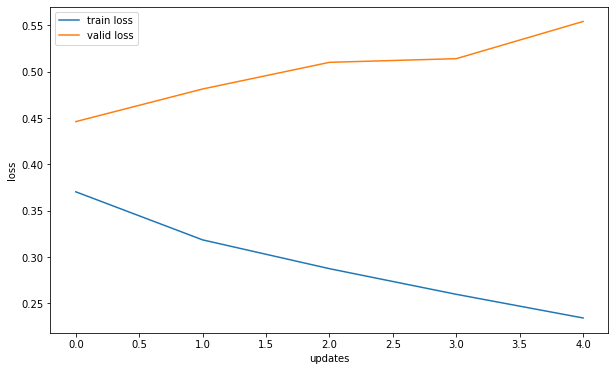

In [48]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

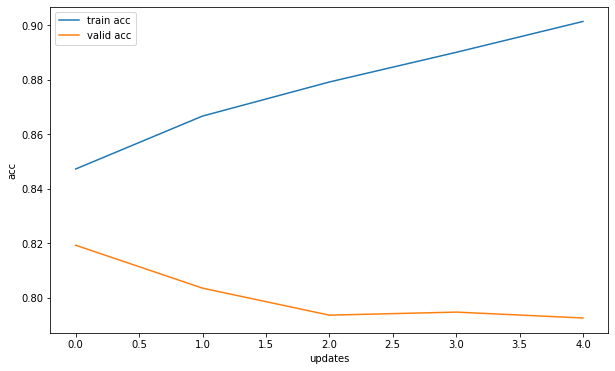

In [49]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [50]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.456 | Test Acc: 81.51%


In [88]:
#@title Test on some random news
test_str = "Ahoy, this movie is a piece of art"
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([  0,   5,  27,  22,  13,   6, 294,   7, 265], device='cuda:0')

In [89]:
text_list = [x.item() for x in text]
text_list

[0, 5, 27, 22, 13, 6, 294, 7, 265]

In [90]:
[mapping[num] for num in text_list]

['<unk>', ',', 'this', 'movie', 'is', 'a', 'piece', 'of', 'art']

In [91]:
text = text.reshape(1, -1)  #because batch_size is 1

In [92]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [93]:
text.shape

torch.Size([1, 9])

In [94]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [95]:
predict(text, text_length)

tensor([3], device='cuda:0')

In [96]:
#combine all the command above

def prediction(test_list):
    result = list()
    for test_str in test_list:
        text = torch.tensor(text_pipeline(test_str)).to(device)
        text = text.reshape(1, -1)
        text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        result.append((test_str, predicted.item()))
    return result

In [98]:
test_list = [
    'Ahoy, this movie is a piece of art',
    'Ahoy, this movie is so boring',
    'Uay, this is a very nice day',
    'He, I can not believe this is so bad',
    'Well, this guy is so cool' 
    ]

prediction(test_list)

[('Ahoy, this movie is a piece of art', 3),
 ('Ahoy, this movie is so boring', 0),
 ('Uay, this is a very nice day', 3),
 ('He, I can not believe this is so bad', 1),
 ('Well, this guy is so cool', 3)]